# Data Cleaning with Pandas

In this notebook we'll go through a few basic data cleaning steps that should be performed on all new datasets where necessary.

We'll go through the process with both the `orders` and `orderlines` datasets. You can then practice these skills by cleaning the `products` dataset yourself

In [24]:
import pandas as pd

In [25]:
# orders.csv
url = "https://drive.google.com/file/d/1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders = pd.read_csv(path)

# orderlines.csv
url = "https://drive.google.com/file/d/1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines = pd.read_csv(path)

One of the best ways to begin data cleaning is by exploring using `.info()`. This will tell us:
* The shape of the DataFrame
* The names of the columns
* If there are any missing values
* The datatypes of the columns

By exploring the missing values and correcting any incorrect datatypes, we often come across inconsistencies in our data.

Beyond this, we should also have a **check for any duplicate rows**. 

Let's first deal with the duplicates, as it's nice and easy, then we'll explore what `.info()` has to tell us.

## 1.&nbsp; Duplicates
We can check for duplicates using the pandas [.duplicated()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) method. 

We can then delete these rows, if we wish, using [.drop_duplicates()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)

In [26]:
# orders
orders.duplicated().sum()

0

In [27]:
# orderlines
orderlines.duplicated().sum()

0

We have no duplicate rows in either DataFrame. Easy, there is no problem to solve. Normally though, if there were some duplicates, we'd drop the extra rows.

# 2.&nbsp; `.info()`

In [28]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


* `total_paid` has 5 missing values
* `created_date` should become datetime datatype

In [29]:
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


* `date` should be a datetime datatype
* `unit_price` should be a float datatype

## 3.&nbsp; Missing values

### 3.1.&nbsp; Orders
* `total_paid` has 5 missing values

In [30]:
print(f"5 missing values represents {((orders.total_paid.isna().sum() / orders.shape[0])*100).round(5)}% of the rows in our DataFrame")

5 missing values represents 0.0022% of the rows in our DataFrame


As there is such a tiny amount of missing values, we will simply delete these rows, as we have enough data without them.

In [31]:
orders = orders.loc[~orders.total_paid.isna(), :]

Should you have a significant number of missing values in the future, you have a choice: 
+ you can impute the values
+ you can take the values from other DataFrames, if they are present there
+ you can delete the values
+ or any number of other creative solutions

Please, always consider how much time you have on your project, and what impact your method of choice will have on your final assesment.

### 3.2.&nbsp; Orderlines
There are no missing values in `orderlines`

## 4.&nbsp; Datatypes

### 4.1.&nbsp; Orders
* `created_date` should become datetime datatype

In [32]:
orders["created_date"] = pd.to_datetime(orders["created_date"])

In [33]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226904 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226904 non-null  int64         
 1   created_date  226904 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226904 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.7+ MB


### 4.1.&nbsp; Orderlines
* `date` should be a datetime datatype
* `unit_price` should be a float datatype

#### 4.1.1.&nbsp; `date`

In [34]:
orderlines["date"] = pd.to_datetime(orderlines["date"])

#### 4.1.2.&nbsp;`unit_price`

In [36]:
#orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

As you can see when we try to convert `unit_price` to a numerical datatype, we receive a `ValueError` telling us that pandas doesn't understand the number `1.137.99`. This is probably because numbers cannot have 2 decimal points. Let's see if there are any other numbers like this.

In [37]:
orderlines.unit_price.astype(str).str.contains("\d+\.\d+\.\d+").value_counts()

False    257814
True      36169
Name: unit_price, dtype: int64

Looks like over 36000 rows in `orderlines` are affected by this problem. Let's work out how much that is as a percentage of our total data.

In [38]:
two_dot_percentage = (
                        (orderlines.unit_price.str.contains("\d+\.\d+\.\d+").value_counts()[1] / orderlines.shape[0])*100
                     ).round(2)
print(f"The 2 dot problem represents {two_dot_percentage}% of the rows in our DataFrame")

The 2 dot problem represents 12.3% of the rows in our DataFrame


This is a bit of a tricky decision as 12.3% is a significant amount of our data... and we might even end up losing a larger portion of our data than this too. For the moment we will delete the rows as we only have 2 weeks for this project and I'd like some quick, accurate results to show. If we have time at the end, we can come back and investigate this problem further, maybe there's a solution?

Each row of `orderlines` represents a product in an order. For example, if order number 175 contained 3 seperate products, then order 175 would have 3 rows in `orderlines`, one row for each of the products. If 2 of those products have 'normal' prices (14.99, 15.85) and 1 has a price with 2 decimal points (1.137.99), we need to remove the whole order and not just the affected row. If we only remove the row with 2 decimal places then any later analysis about products and prices could be misleading.

We therefore need to find the order numbers associated with the rows that have 2 decimal points, and then remove all the associated rows.

In [39]:
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]

In [40]:
orderlines.shape[0]

216250

We still have 216250 rows in orderlines to work with. This should be more than enough for our evaluation.

Now that all of the 2 decimal point prices have been removed, let's try again to convert the column `unit_price` to the correct datatype.

In [41]:
orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

It worked perfectly

Now save the cleaned dataframes as csv files:

In [42]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html?highlight=to_csv

orderlines.to_csv("orderlines_cl.csv", index=False)
orders.to_csv("orders_cl.csv", index=False)


In [53]:
orderlines.describe()

,id,id_order,product_id,product_quantity,unit_price
count,2.162500e+05,216250.000000,216250.0,216250.000000,216250.000000
mean,1.372496e+06,408967.391727,0.0,1.136698,164.636160
std,1.517563e+05,65892.054168,0.0,3.292203,219.630604
min,1.119109e+06,241319.000000,0.0,1.000000,-119.000000
25%,1.240903e+06,351866.250000,0.0,1.000000,29.740000
50%,1.366966e+06,406548.500000,0.0,1.000000,69.990000
75%,1.503947e+06,465795.500000,0.0,1.000000,184.580000
max,1.650203e+06,527401.000000,0.0,999.000000,999.990000


In [59]:
#orderlines.hist("product_quantity");

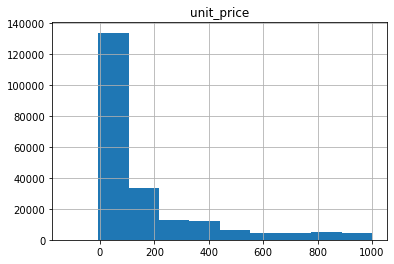

In [50]:
orderlines.hist("unit_price");

In [60]:
orderlines.unit_price.nsmallest(10)

77008   -119.0
53515      0.0
53530      0.0
57811      0.0
58425      0.0
58529      0.0
58629      0.0
58647      0.0
58652      0.0
58656      0.0
Name: unit_price, dtype: float64

<AxesSubplot:>

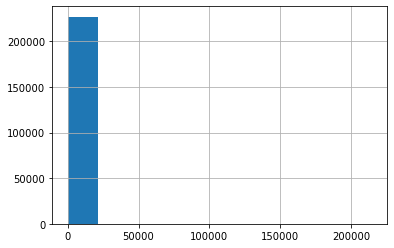

In [66]:
orders.total_paid.hist()

In [70]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226904 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      226904 non-null  int64         
 1   created_date  226904 non-null  datetime64[ns]
 2   total_paid    226904 non-null  float64       
 3   state         226904 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.7+ MB


<AxesSubplot:xlabel='state'>

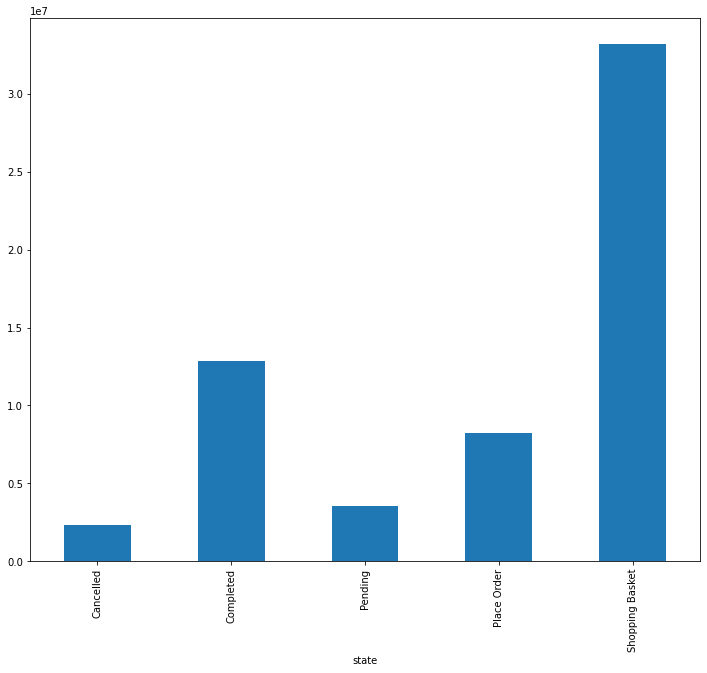

In [80]:
orders_merged = orderlines.merge(orders, left_on="id_order", right_on="order_id")
orders_merged.groupby("state").total_paid.sum().plot.bar(figsize=(12,10))

In [ ]:
orders_merged.groupby("state").total_paid.sum().plot.bar(figsize=(12,10))

(
    ol_df
    .resample("M", on="date")["product_quantity"]
    .sum()
    .sort_values(ascending=False)
)

In [76]:
orders_merged.groupby("order_id").total_paid.sum().nlargest(20)

order_id
464858    99648.10
376851    90989.60
498342    89352.00
361853    87020.97
410252    84598.44
334803    79981.00
518368    69730.20
358372    58790.97
346221    55930.71
342607    55253.70
433281    54395.01
352560    47362.28
422784    47302.04
431635    42988.90
349133    39399.84
428186    37806.72
330978    37368.04
335057    32720.00
352573    32031.72
416480    27748.32
Name: total_paid, dtype: float64

**TODO** ORDERS_CL.CSV
- `unit_price` has one negative value of -119
- `unit_price` also has some 0.00 values --> Yanish: They are cancelled orders. But still the uni_price should have a value and `total_paid` should be 0


**TODO** ORDERLINES_CL.CSV
- `total_paid` has a median of 112.99 and a mean of 569.22 --> looks like a skewed data set (high outliers)

**INFO**
- `state` = Shopping Basket has by far the highest amount of total_paid (4 times more than Place Order and Completed)

**IDEAS**
WHEN SHOULD WE BE GIVING DISCOUTS? AND ON WHICH ITEMS?
1. items which are in big number and not getting sold. (?)
2. on items which are about to get out of stocks (?)
3. are there specific days of the week / or time of the month where we can give discounts
4. do you give discounts when you are selling more? Or do you give discount to sell even more?
5. Are the orders that are being completed / cancelled ... holding a discount? What are the differences between the groups?

--> Have a slide on sales on a timeframe

# Challenge: Clean the `products` DataFrame
Now it's your turn. Use the lessons you learnt above and clean the products DataFrame. You don't have to copy exactly what we did. Think about the consequences of your actions, sometimes it is ok to delete rows, other times you may wish to come up with more creative solutions.

In [21]:
# products.csv
url = "https://drive.google.com/file/d/1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products = pd.read_csv(path)

In [22]:
# your code here
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


### Look for Duplicates

In [23]:
# your code here
products.duplicated().sum()

8746

### Look for Missing values


In [ ]:
# your code here

### Check / Change Data types

In [ ]:
# your code here